What does this notebook do:

    - loads the charge distribution data.
    - computes the net heating per grain, full calculation.
    - takes the GTn parameter and computes the parametric net heating.
    - compares both distributions and gives the percentiles.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pickle
import numpy as np
from   matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import time

import compute_charge_dist as fz
import PeHeat_Functions as peh
import parametric_fz as fzpar
import parametric_PeHeat as parPeH

Loading the library to compute the charge distribution of dust grains.


In [2]:
def index_fz(npoints, zminmax, fdist):

    ffz = []
    cum = 0
    for index in range(npoints):
        zmin = zminmax[index*2]
        zmax = zminmax[index*2+1]
        znum = int(abs(zmin) + zmax + 1)
        
        #print(zmin, zmax)
        #print(znum)
        
        ffz.append(0)
        ffz[-1] = []
        for j in range(znum):
            fhere = fdist[cum+j]
            ffz[-1].append(fhere)
            #print("filling the array", j)
        #print(ffz[-1])
        cum += znum
    
    return ffz

In [3]:
grain_type = "silicate"
#grain_type = "carbonaceous"

########################################################################################
pcent      = 1
grain_size = 3

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist3 = pickle.load(pkl_file)
pkl_file.close

Qabs3 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 5

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist5 = pickle.load(pkl_file)
pkl_file.close

Qabs5 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 10

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist10 = pickle.load(pkl_file)
pkl_file.close

Qabs10 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 50

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist50 = pickle.load(pkl_file)
pkl_file.close

Qabs50 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 100

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist100 = pickle.load(pkl_file)
pkl_file.close

Qabs100 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 500

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist500 = pickle.load(pkl_file)
pkl_file.close

Qabs500 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 1000

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist1000 = pickle.load(pkl_file)
pkl_file.close

Qabs1000 = fz.get_QabsTable(grain_type, grain_size)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [4]:
fdist3 = index_fz(len(cdist3["nH"]), cdist3["zminmax"], cdist3["fdist"])
fdist5 = index_fz(len(cdist5["nH"]), cdist5["zminmax"], cdist5["fdist"])
fdist10 = index_fz(len(cdist10["nH"]), cdist10["zminmax"], cdist10["fdist"])

In [5]:
def Full_netHeating(grain_size, grain_type, nH, Gtot, temp, xe, zminmax, fdist, Qabs):
    """
    Given the charge distribution, and some ISM parameters, compute the net heating by a single dust grain.
    """
    Zmin_sil, Zmax_sil = fz.get_Zmin(grain_size, grain_type), fz.get_Zmax(grain_size, grain_type)
    Znum_sil = int(Zmax_sil + abs(Zmin_sil) +1)
    ZZ_sil = np.linspace(Zmin_sil, Zmax_sil, num=Znum_sil)

    Gamma_dotdot_Z_sil = np.zeros_like(ZZ_sil, dtype=np.float)

    for i in range(Znum_sil):
        Gamma_dotdot_Z_sil[i] = peh.get_Gamma_pe_dotdot(grain_size, ZZ_sil[i], grain_type, 0.0, Qabs, G0=1.7)

    Gamma_a = np.zeros_like(nH, dtype=np.float)
    Cooling = np.zeros_like(nH, dtype=np.float)
    cum = 0

    #for index in range(10):
    for index in range(len(Gamma_a)):

        zmin = zminmax[index*2]
        zmax = zminmax[index*2+1]
        znum = int(abs(zmin) + zmax + 1)

        Gamma_dotdot_Z_sil_scaled = Gamma_dotdot_Z_sil*(Gtot[index]/1.7)

        ZZfz = np.arange(zmin, zmax+1, 1)
        ffz  = fdist[index]
        #print(ZZfz)
        #print(ffz)

        Gamma_a[index]= peh.Gamma_per_grain(ZZ_sil, Gamma_dotdot_Z_sil_scaled, ZZfz, ffz)
        
        #Cooling[index] = peh.Cool_per_Grain(grain_size, grain_type, ZZfz, ffz, nH[index], xe[index], temp[index])

    netHeat = Gamma_a #- Cooling
    
    return netHeat

In [6]:
nH3, Gtot3, temp3, xe3, zminmax3, fdist3                   = cdist3["nH"], cdist3["G"]+cdist3["G_CR"], cdist3["temp"],cdist3["new_xe"], cdist3["zminmax"], fdist3
nH5, Gtot5, temp5, xe5, zminmax5, fdist5                   = cdist5["nH"], cdist5["G"]+cdist5["G_CR"], cdist5["temp"],cdist5["new_xe"], cdist5["zminmax"], fdist5
nH10, Gtot10, temp10, xe10, zminmax10, fdist10             = cdist10["nH"], cdist10["G"]+cdist10["G_CR"], cdist10["temp"],cdist10["new_xe"], cdist10["zminmax"], fdist10
nH50, Gtot50, temp50, xe50, zminmax50, fdist50             = cdist50["nH"], cdist50["G"]+cdist50["G_CR"], cdist50["temp"],cdist50["new_xe"], cdist50["zminmax"], cdist50["fdist"]
nH100, Gtot100, temp100, xe100, zminmax100, fdist100       = cdist100["nH"], cdist100["G"]+cdist100["G_CR"], cdist100["temp"],cdist100["new_xe"], cdist100["zminmax"], cdist100["fdist"]
nH500, Gtot500, temp500, xe500, zminmax500, fdist500       = cdist500["nH"], cdist500["G"]+cdist500["G_CR"], cdist500["temp"],cdist500["new_xe"], cdist500["zminmax"], cdist500["fdist"]
nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000 = cdist1000["nH"], cdist1000["G"]+cdist1000["G_CR"], cdist1000["temp"],cdist1000["new_xe"], cdist1000["zminmax"], cdist1000["fdist"]

In [7]:
netHeat3 = Full_netHeating(3.5, grain_type, nH3, Gtot3, temp3, xe3, zminmax3, fdist3, Qabs3)
netHeat5 = Full_netHeating(5., grain_type, nH5, Gtot5, temp5, xe5, zminmax5, fdist5, Qabs5)
netHeat10 = Full_netHeating(10., grain_type, nH10, Gtot10, temp10, xe10, zminmax10, fdist10, Qabs10)
netHeat50 = Full_netHeating(50., grain_type, nH50, Gtot50, temp50, xe50, zminmax50, fdist50, Qabs50)
netHeat100 = Full_netHeating(100., grain_type, nH100, Gtot100, temp100, xe100, zminmax100, fdist100, Qabs100)
netHeat500 = Full_netHeating(500., grain_type, nH500, Gtot500, temp500, xe500, zminmax500, fdist500, Qabs500)
netHeat1000 = Full_netHeating(1000., grain_type, nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000, Qabs1000)

#### Now parametric heating:

In [8]:
import parametric_PeHeat as peHpar

In [9]:
netHeat3_par,netHeat5_par,netHeat10_par,netHeat50_par = np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3)
netHeat100_par = np.zeros_like(Gtot3)

for i in range(85943):
    netHeat3_par[i]    = peHpar.get_Gamma_dot_par(Gtot3[i],    temp3[i],    nH3[i]*xe3[i],         3.5, grain_type)
    netHeat5_par[i]    = peHpar.get_Gamma_dot_par(Gtot5[i],    temp5[i],    nH5[i]*xe5[i],          5., grain_type)
    netHeat10_par[i]   = peHpar.get_Gamma_dot_par(Gtot10[i],   temp10[i],   nH10[i]*xe10[i],       10., grain_type)
    netHeat50_par[i]   = peHpar.get_Gamma_dot_par(Gtot50[i],   temp50[i],   nH50[i]*xe50[i],       50., grain_type)
    netHeat100_par[i]  = peHpar.get_Gamma_dot_par(Gtot100[i],  temp100[i],  nH100[i]*xe100[i],    100., grain_type)


In [10]:
netHeat500_par,netHeat1000_par = np.zeros_like(Gtot500), np.zeros_like(Gtot1000)

for i in range(len(Gtot500)):
    netHeat500_par[i]  = peHpar.get_Gamma_dot_par(Gtot500[i],  temp500[i],  nH500[i]*xe500[i],    500., grain_type)
for i in range(len(Gtot1000)):
    netHeat1000_par[i] = peHpar.get_Gamma_dot_par(Gtot1000[i], temp1000[i], nH1000[i]*xe1000[i], 1000., grain_type)

In [11]:
# Compute relative error
relerror3    = np.percentile((np.abs(netHeat3    - netHeat3_par)    / netHeat3), [25,50,75])*100
relerror5    = np.percentile((np.abs(netHeat5    - netHeat5_par)    / netHeat5), [25,50,75])*100
relerror10   = np.percentile((np.abs(netHeat10   - netHeat10_par)   / netHeat10), [25,50,75])*100
relerror50   = np.percentile((np.abs(netHeat50   - netHeat50_par)   / netHeat50), [25,50,75])*100
relerror100  = np.percentile((np.abs(netHeat100  - netHeat100_par)  / netHeat100), [25,50,75])*100
relerror500  = np.percentile((np.abs(netHeat500  - netHeat500_par)  / netHeat500), [25,50,75])*100
relerror1000 = np.percentile((np.abs(netHeat1000 - netHeat1000_par) / netHeat1000), [25,50,75])*100

In [12]:
print(netHeat3[0], netHeat3_par[0])

(1.1130499452718188e-21, 4.4034835838779013e-22)


In [13]:
pwd

u'/home/jcibanezm/codes/PeHeat_Paper'

In [14]:
# Print table
print("")
print(" Relative error table")
print("3.5 \t & %.1f \t & %.1f \t & %.1f"%(relerror3[0],     relerror3[1], relerror3[2]))
print("5 \t & %.1f \t & %.1f \t & %.1f"%(  relerror5[0],     relerror5[1], relerror5[2]))
print("10 \t & %.1f \t & %.1f \t & %.1f"%( relerror10[0],    relerror10[1], relerror10[2]))
print("50 \t & %.1f \t & %.1f \t & %.1f"%( relerror50[0],    relerror50[1], relerror50[2]))
print("100 \t & %.1f \t & %.1f \t & %.1f"%(relerror100[0],   relerror100[1], relerror100[2]))
print("500 \t & %.1f \t & %.1f \t & %.1f"%(relerror500[0],   relerror500[1], relerror500[2]))
print("1000 \t & %.1f \t & %.1f \t & %.1f"%(relerror1000[0], relerror1000[1], relerror1000[2]))


 Relative error table
3.5 	 & 42.7 	 & 61.0 	 & 71.2
5 	 & 7.6 	 & 12.4 	 & 21.0
10 	 & 2.7 	 & 6.3 	 & 9.9
50 	 & 3.6 	 & 10.4 	 & 19.2
100 	 & 5.2 	 & 11.3 	 & 24.6
500 	 & 10.1 	 & 13.5 	 & 16.8
1000 	 & 2.8 	 & 4.8 	 & 17.7


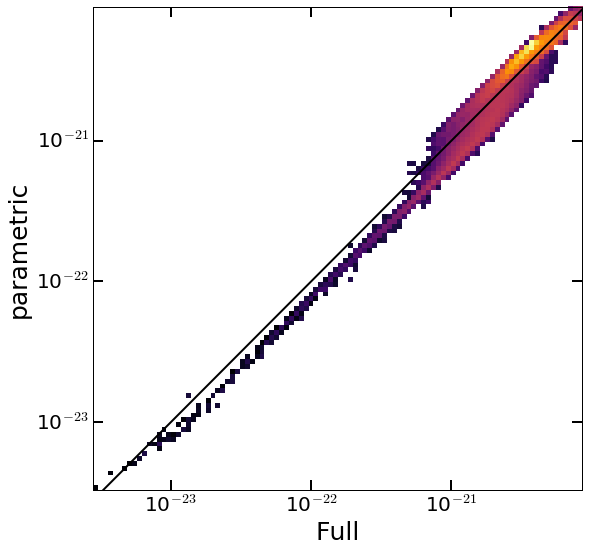

In [116]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0.14, 0.11, 0.85, 0.84])
from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value

ax.hist2d(np.log10(netHeat3), np.log10(netHeat3_par*1.3),weights=temp3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
#ax.set_ylabel("T [K]", fontsize=25)
#
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=20, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=20, direction="in")

#ax.set_ylim(-0.9, 4.99)
ax.set_ylabel("parametric", fontsize=25)
ax.set_xlabel("Full", fontsize=25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

#ax.set_yscale("log")
fig.show()


---
# Now for carbonaceous

In [106]:
#grain_type = "silicate"
grain_type = "carbonaceous"

########################################################################################
pcent      = 1
grain_size = 3

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist3 = pickle.load(pkl_file)
pkl_file.close

Qabs3 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 5

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist5 = pickle.load(pkl_file)
pkl_file.close

Qabs5 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 10

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist10 = pickle.load(pkl_file)
pkl_file.close

Qabs10 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 50

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist50 = pickle.load(pkl_file)
pkl_file.close

Qabs50 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 1
grain_size = 100

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist100 = pickle.load(pkl_file)
pkl_file.close

Qabs100 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 500

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist500 = pickle.load(pkl_file)
pkl_file.close

Qabs500 = fz.get_QabsTable(grain_type, grain_size)

########################################################################################
pcent      = 0.1
grain_size = 1000

save_dir = "/home/jcibanezm/Dropbox/codes/run/ChargeStatisticsAnalysis/Daikaiju"
filename = "fz_%.4iAA_%s_CR_True_%i_pcent.pkl"%(grain_size, grain_type, pcent) 

pkl_file    = open("%s/%s"%(save_dir, filename), "rb")
cdist1000 = pickle.load(pkl_file)
pkl_file.close

Qabs1000 = fz.get_QabsTable(grain_type, grain_size)

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain
I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [107]:
fdist3 = index_fz(len(cdist3["nH"]), cdist3["zminmax"], cdist3["fdist"])
fdist5 = index_fz(len(cdist5["nH"]), cdist5["zminmax"], cdist5["fdist"])
fdist10 = index_fz(len(cdist10["nH"]), cdist10["zminmax"], cdist10["fdist"])

In [108]:
nH3, Gtot3, temp3, xe3, zminmax3, fdist3                   = cdist3["nH"], cdist3["G"]+cdist3["G_CR"], cdist3["temp"],cdist3["new_xe"], cdist3["zminmax"], fdist3
nH5, Gtot5, temp5, xe5, zminmax5, fdist5                   = cdist5["nH"], cdist5["G"]+cdist5["G_CR"], cdist5["temp"],cdist5["new_xe"], cdist5["zminmax"], fdist5
nH10, Gtot10, temp10, xe10, zminmax10, fdist10             = cdist10["nH"], cdist10["G"]+cdist10["G_CR"], cdist10["temp"],cdist10["new_xe"], cdist10["zminmax"], fdist10
nH50, Gtot50, temp50, xe50, zminmax50, fdist50             = cdist50["nH"], cdist50["G"]+cdist50["G_CR"], cdist50["temp"],cdist50["new_xe"], cdist50["zminmax"], cdist50["fdist"]
nH100, Gtot100, temp100, xe100, zminmax100, fdist100       = cdist100["nH"], cdist100["G"]+cdist100["G_CR"], cdist100["temp"],cdist100["new_xe"], cdist100["zminmax"], cdist100["fdist"]
nH500, Gtot500, temp500, xe500, zminmax500, fdist500       = cdist500["nH"], cdist500["G"]+cdist500["G_CR"], cdist500["temp"],cdist500["new_xe"], cdist500["zminmax"], cdist500["fdist"]
nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000 = cdist1000["nH"], cdist1000["G"]+cdist1000["G_CR"], cdist1000["temp"],cdist1000["new_xe"], cdist1000["zminmax"], cdist1000["fdist"]

In [109]:
netHeat3 = Full_netHeating(3.5, grain_type, nH3, Gtot3, temp3, xe3, zminmax3, fdist3, Qabs3)
netHeat5 = Full_netHeating(5., grain_type, nH5, Gtot5, temp5, xe5, zminmax5, fdist5, Qabs5)
netHeat10 = Full_netHeating(10., grain_type, nH10, Gtot10, temp10, xe10, zminmax10, fdist10, Qabs10)
netHeat50 = Full_netHeating(50., grain_type, nH50, Gtot50, temp50, xe50, zminmax50, fdist50, Qabs50)
netHeat100 = Full_netHeating(100., grain_type, nH100, Gtot100, temp100, xe100, zminmax100, fdist100, Qabs100)
netHeat500 = Full_netHeating(500., grain_type, nH500, Gtot500, temp500, xe500, zminmax500, fdist500, Qabs500)
netHeat1000 = Full_netHeating(1000., grain_type, nH1000, Gtot1000, temp1000, xe1000, zminmax1000, fdist1000, Qabs1000)

In [110]:
netHeat3_par,netHeat5_par,netHeat10_par,netHeat50_par = np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3), np.zeros_like(Gtot3)
netHeat100_par,netHeat500_par,netHeat1000_par = np.zeros_like(Gtot3), np.zeros_like(Gtot500), np.zeros_like(Gtot1000)

for i in range(85943):
    netHeat3_par[i]    = peHpar.get_Gamma_dot_par(Gtot3[i],    temp3[i],    nH3[i]*xe3[i],         3.5, grain_type)
    netHeat5_par[i]    = peHpar.get_Gamma_dot_par(Gtot5[i],    temp5[i],    nH5[i]*xe5[i],          5., grain_type)
    netHeat10_par[i]   = peHpar.get_Gamma_dot_par(Gtot10[i],   temp10[i],   nH10[i]*xe10[i],       10., grain_type)
    netHeat50_par[i]   = peHpar.get_Gamma_dot_par(Gtot50[i],   temp50[i],   nH50[i]*xe50[i],       50., grain_type)
    netHeat100_par[i]  = peHpar.get_Gamma_dot_par(Gtot100[i],  temp100[i],  nH100[i]*xe100[i],    100., grain_type)

for i in range(len(Gtot500)):
    netHeat500_par[i]  = peHpar.get_Gamma_dot_par(Gtot500[i],  temp500[i],  nH500[i]*xe500[i],    500., grain_type)
for i in range(len(Gtot1000)):
    netHeat1000_par[i] = peHpar.get_Gamma_dot_par(Gtot1000[i], temp1000[i], nH1000[i]*xe1000[i], 1000., grain_type)

In [111]:
differror3    = (netHeat3    - netHeat3_par)    / netHeat3
differror5    = (netHeat5    - netHeat5_par)    / netHeat5
differror10   = (netHeat10   - netHeat10_par)   / netHeat10
differror50   = (netHeat50   - netHeat50_par)   / netHeat50
differror100  = (netHeat100  - netHeat100_par)  / netHeat100
differror500  = (netHeat500  - netHeat500_par)  / netHeat500
differror1000 = (netHeat1000 - netHeat1000_par) / netHeat1000

In [112]:
%matplotlib inline

In [113]:
print(netHeat3[39379])
print(netHeat3_par[39379])

4.62276125022e-21
3.24563920863e-21


In [106]:
print(np.argmax(differror3))
print(np.argmin(differror3))

39379
59225


In [109]:
Gtot3[39379]*np.sqrt(temp3[39379])/(nH3[39379]*xe3[39379])

3988.6768766539421

In [116]:
zc = fzpar.get_zcent(Gtot3[39379], temp3[39379], nH3[39379]*xe3[39379], 'carbonaceous', 3.5)
zw = fzpar.get_zwidth(3.5, 'carbonaceous', zc)
zzz = np.arange(np.floor(zc-3*zw), np.ceil(zc+3*zw))
chargedist = 1./(np.sqrt(2.*np.pi)*zw)*np.exp(-0.5*(zc-zzz)**2/zw**2)
print(chargedist)

[  3.12366047e-06   1.70117347e-02   7.29978221e-01   2.46801460e-01]


In [119]:
fdist3[39379]

[0.02635913205139024,
 0.63825004571734634,
 0.33068515824469613,
 0.0047056639865673969]

In [126]:
print(cdist3["zminmax"][2*39379], cdist3["zminmax"][2*39379+1])

(-1.0, 2.0)


In [124]:
print(zzz)

[-2. -1.  0.  1.]


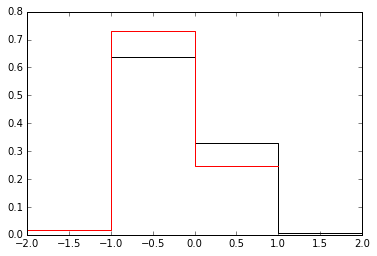

In [130]:
plt.plot(np.arange(-1, 3), fdist3[39379], "-k", linestyle="steps")
plt.plot(zzz, chargedist, "-r", linestyle="steps")

In [151]:
# Plot, full calculation of photoelectric heating
PeHeat_par = peHpar.get_Gamma_dotdot_par(3.5, Gtot3[39379], zzz , "carbonaceous")
PeHeat_par = np.concatenate(([PeHeat_par[0]], PeHeat_par))
zz2 = np.concatenate(([zzz[0]-1], zzz))
# plot parametric equation of photoelectric heating
Qabs = fz.get_QabsTable("carbonaceous", 3.5)
PeHeat_tot = np.zeros_like(np.arange(-1,3), dtype=np.float)
ZZtot = np.arange(-1,3)
for i in range(len(PeHeat_tot)):
    PeHeat_tot[i] = peh.get_Gamma_pe_dotdot(3.5, ZZtot[i], "carbonaceous", cdist3["Ntot"][39379], Qabs)
PeHeat_tot = np.concatenate(([PeHeat_tot[0]], PeHeat_tot))
ZZtot = np.concatenate(([ZZtot[0]-1], ZZtot))

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [148]:
print(PeHeat_tot)

[  5.07833652e-20   5.01587581e-21   2.08476500e-22   0.00000000e+00]


In [137]:
np.log10(PeHeat_par)

array([-19.1728342 , -19.79810272, -20.42337124, -21.04863975])

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


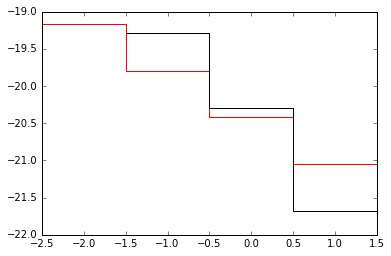

In [152]:
plt.plot(zz2+0.5, np.log10(PeHeat_par), "-r", linestyle="steps")
plt.plot(ZZtot+0.5, np.log10(PeHeat_tot), "-k", linestyle="steps")

In [204]:
Heat_tot = np.sum(fdist3[39379]*PeHeat_tot[1:len(PeHeat_tot)])
Heat_par = np.sum(chargedist*PeHeat_par[1:len(PeHeat_par)])*1.4
print("Total = ", Heat_tot)
print("Param = ", Heat_par)
print("error = ", (Heat_tot - Heat_par)/Heat_tot*100)

('Total = ', 4.6089284747242838e-21)
('Param = ', 4.543699869906907e-21)
('error = ', 1.415266155139864)


In [205]:
# Cooling
Cool_par = peHpar.Cooling_par(3.5, Gtot3[39379],temp3[39379], nH3[39379]*xe3[39379])*1.85
Cool_tot = peh.Cool_per_Grain(3.5, "carbonaceous", np.arange(-1, 3), fdist3[39379], nH3[39379], xe3[39379], temp3[39379])

In [206]:
print("Cool tot = ", Cool_tot)
print("Cool par = ", Cool_par)
print("error    = ", (Cool_tot-Cool_par)/Cool_tot*100)

('Cool tot = ', 4.625362782316994e-21)
('Cool par = ', 4.6564277204138722e-21)
('error    = ', -0.67162165561674825)


In [208]:
netHeat_tot = Heat_tot - Cool_tot
#netHeat_par = Heat_par - Cool_par*1.295
netHeat_par = Heat_par - Cool_tot
print("NetHeating tot = ", netHeat_tot)
print("NetHeating par = ", netHeat_par)
print("error          = ", (netHeat_tot-netHeat_par)/netHeat_tot*100)

('NetHeating tot = ', -1.6434307592710197e-23)
('NetHeating par = ', -8.1662912410086942e-23)
('error          = ', -396.90509897910363)


---

In [ ]:
# Check where the calculation is more problematic:
# Molecular phase
# Cold phase
# Warm phase



---

In [110]:
Gtot3[59225]*np.sqrt(temp3[59225])/(nH3[59225]*xe3[59225])

8376.5965960930262

In [112]:
print(differror3[59225])

-255.969115399


In [114]:
print(netHeat3[59225])
print(netHeat3_par[59225])

1.03547173505e-23
2.66084255777e-21


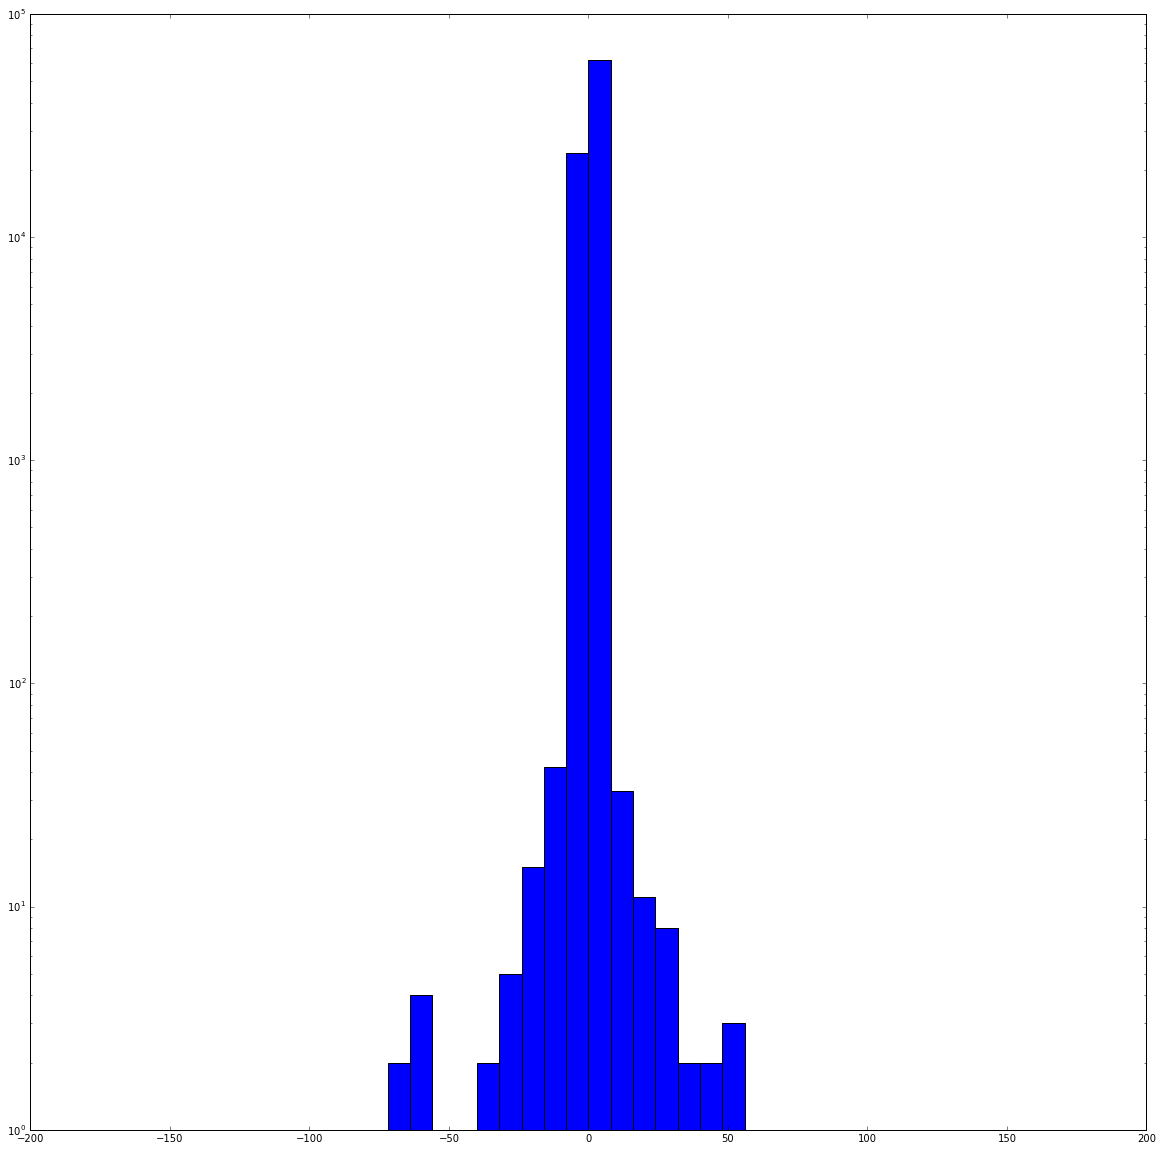

In [104]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111)
ax.hist(differror3, bins=50, range=[-200, 200])
ax.set_yscale("log")

ax.set_xlim(-200, 200)

fig.show()

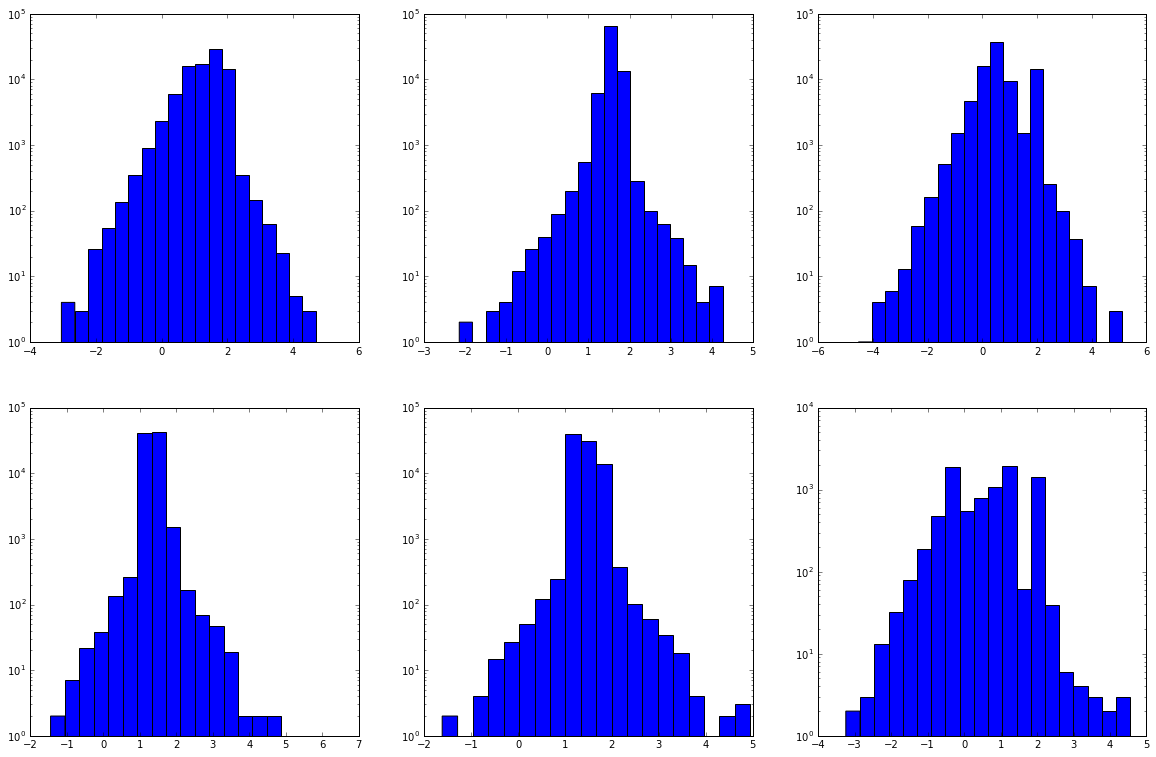

In [100]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(331)
ax.hist(np.log10(abs(differror3)*100), bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(332)
ax.hist(np.log10(abs(differror5)*100), bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(333)
ax.hist(np.log10(abs(differror10)*100), bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(334)
ax.hist(np.log10(abs(differror50)*100), bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(335)
ax.hist(np.log10(abs(differror100)*100), bins=20)
ax.set_yscale("log")

ax = fig.add_subplot(336)
ax.hist(np.log10(abs(differror500)*100), bins=20)
ax.set_yscale("log")


fig.show()

ValueError: The weights and list don't have the same length.

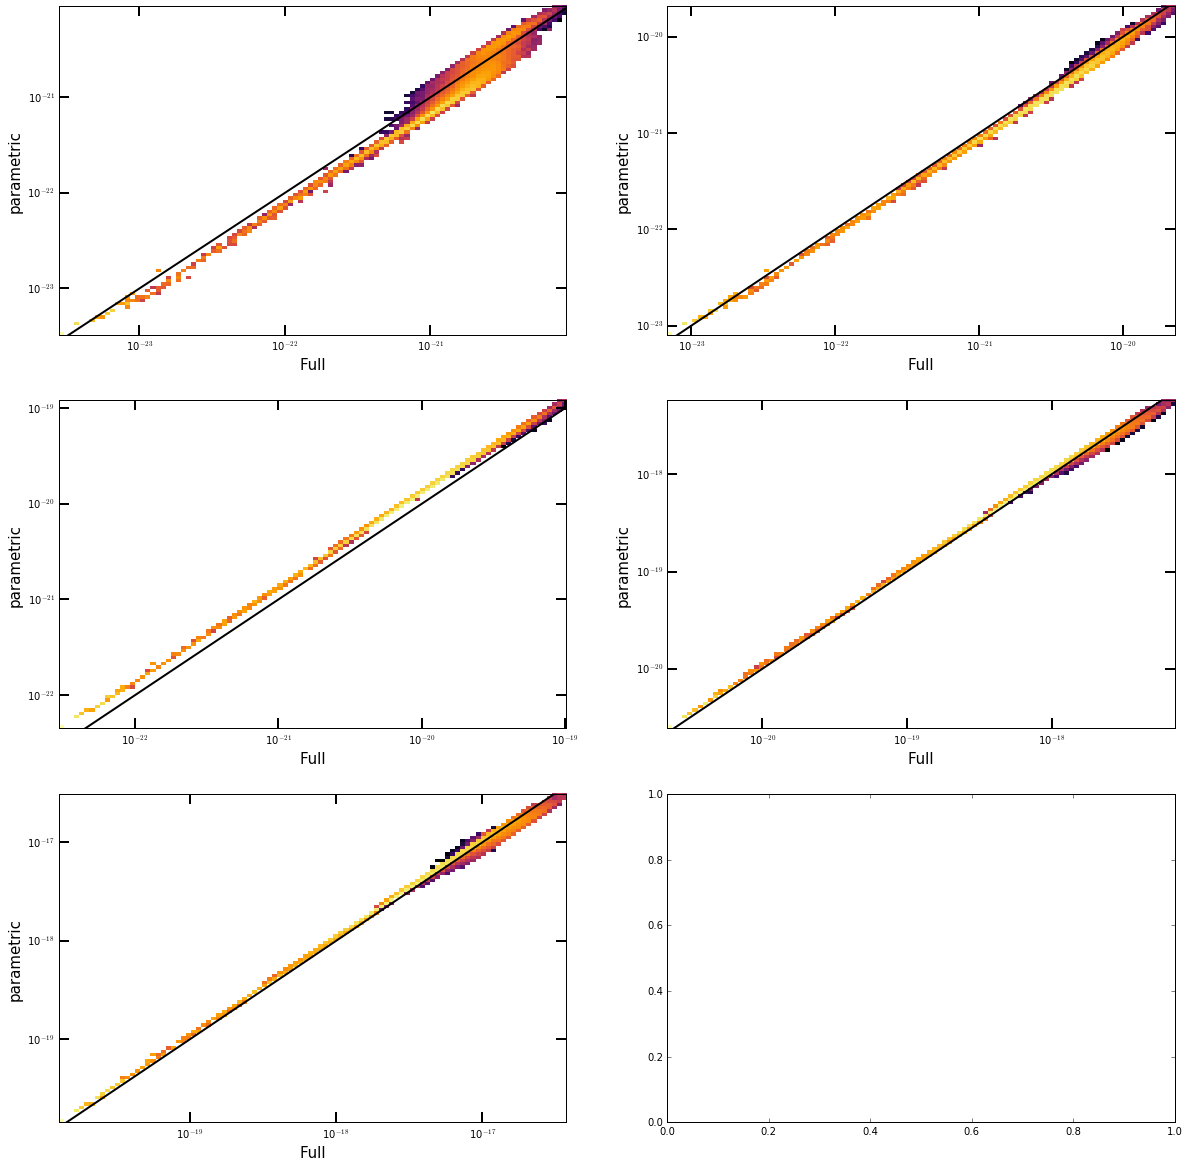

In [114]:
fig = plt.figure(figsize=(20,20))
#ax = fig.add_axes([0.14, 0.11, 0.85, 0.84])
from matplotlib.ticker import MaxNLocator
def format_func(value, tick_number):
    return "10$^{%i}$"%value

ax = fig.add_subplot(321)
ax.hist2d(np.log10(netHeat3), np.log10(netHeat3_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


ax = fig.add_subplot(322)
ax.hist2d(np.log10(netHeat5), np.log10(netHeat5_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


ax = fig.add_subplot(323)
ax.hist2d(np.log10(netHeat10), np.log10(netHeat10_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


ax = fig.add_subplot(324)
ax.hist2d(np.log10(netHeat50), np.log10(netHeat50_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


ax = fig.add_subplot(325)
ax.hist2d(np.log10(netHeat100), np.log10(netHeat100_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


ax = fig.add_subplot(326)
ax.hist2d(np.log10(netHeat500), np.log10(netHeat500_par*1.3),weights=nH3, bins=100, norm=LogNorm(), cmap="inferno")
ax.plot([-25, -15],[-25, -15], "-k", linewidth=2)
ax.tick_params(axis='both', which='major', length=10, width=2,  labelsize=10, direction="in")
ax.tick_params(axis='both', which='minor', length=5, width=1.5, labelsize=10, direction="in")
ax.set_ylabel("parametric", fontsize=15)
ax.set_xlabel("Full", fontsize=15)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))


fig.show()


In [81]:
# Compute relative error
relerror3    = np.percentile((np.abs(netHeat3    - netHeat3_par)    / netHeat3),    [25,50,75])*100
relerror5    = np.percentile((np.abs(netHeat5    - netHeat5_par)    / netHeat5),    [25,50,75])*100
relerror10   = np.percentile((np.abs(netHeat10   - netHeat10_par)   / netHeat10),   [25,50,75])*100
relerror50   = np.percentile((np.abs(netHeat50   - netHeat50_par)   / netHeat50),   [25,50,75])*100
relerror100  = np.percentile((np.abs(netHeat100  - netHeat100_par)  / netHeat100),  [25,50,75])*100
relerror500  = np.percentile((np.abs(netHeat500  - netHeat500_par)  / netHeat500),  [25,50,75])*100
relerror1000 = np.percentile((np.abs(netHeat1000 - netHeat1000_par) / netHeat1000), [25,50,75])*100

In [82]:
# Print table
print("")
print(" Relative error table")
print("3.5 \t & %.1f \t & %.1f \t & %.1f"%(relerror3[0],     relerror3[1], relerror3[2]))
print("5 \t & %.1f \t & %.1f \t & %.1f"%(  relerror5[0],     relerror5[1], relerror5[2]))
print("10 \t & %.1f \t & %.1f \t & %.1f"%( relerror10[0],    relerror10[1], relerror10[2]))
print("50 \t & %.1f \t & %.1f \t & %.1f"%( relerror50[0],    relerror50[1], relerror50[2]))
print("100 \t & %.1f \t & %.1f \t & %.1f"%(relerror100[0],   relerror100[1], relerror100[2]))
print("500 \t & %.1f \t & %.1f \t & %.1f"%(relerror500[0],   relerror500[1], relerror500[2]))
print("1000 \t & %.1f \t & %.1f \t & %.1f"%(relerror1000[0], relerror1000[1], relerror1000[2]))


 Relative error table
3.5 	 & 8.8 	 & 27.1 	 & 46.9
5 	 & 26.7 	 & 33.2 	 & 36.5
10 	 & 1.8 	 & 3.7 	 & 7.0
50 	 & 17.7 	 & 21.3 	 & 35.2
100 	 & 17.0 	 & 23.0 	 & 38.5
500 	 & 0.6 	 & 6.0 	 & 19.9
1000 	 & 4.2 	 & 5.2 	 & 13.6
